Import all the Dependencies

In [1]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
!pip install --upgrade tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 238 kB 11.7 MB/s 


In [2]:
from zipfile import ZipFile
zip_ref =ZipFile('/content/drive/MyDrive/DataSets/PlantVillage.zip', "r")
zip_ref.extractall()
zip_ref.close()

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
 "PlantVillage" ,
 shuffle=True,
 image_size=(IMAGE_SIZE,IMAGE_SIZE),
 batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

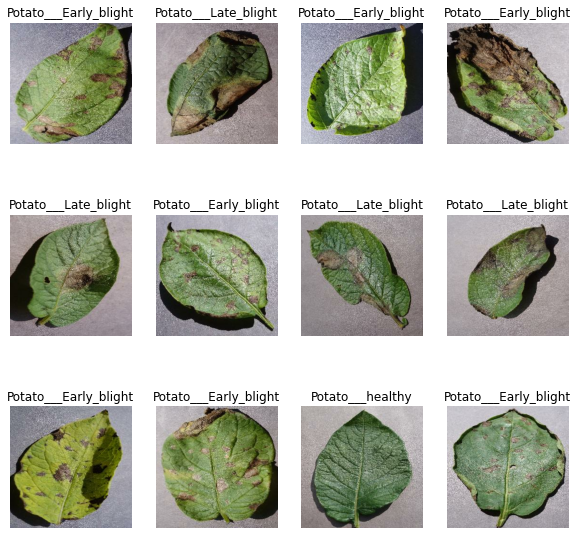

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [7]:
len_train_dataset=0.8*len(dataset)
len_train_dataset

54.400000000000006

In [8]:
train_dataset=dataset.take(54)
remain_dataset=dataset.skip(54)

In [9]:
val_ds=remain_dataset.take(7)
test_ds=remain_dataset.skip(7)

In [10]:
def get_dataset_partitions_tf(ds,train_split = 0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size=len(ds)

  if shuffle:
    ds.shuffle(shuffle_size,seed=12)

  train_size= int(ds_size * train_split)
  val_size = int(val_split*ds_size)

  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(test_ds)

8

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale, 
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 25s 111ms/step - loss: 0.8241 - accuracy: 0.5966 - val_loss: 0.6372 - val_accuracy: 0.7240
Epoch 2/50
54/54 [==============================] - 4s 75ms/step - loss: 0.6168 - accuracy: 0.7523 - val_loss: 0.5307 - val_accuracy: 0.7448
Epoch 3/50
54/54 [==============================] - 4s 72ms/step - loss: 0.4049 - accuracy: 0.8235 - val_loss: 0.3354 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - 4s 72ms/step - loss: 0.3267 - accuracy: 0.8646 - val_loss: 0.2320 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 4s 72ms/step - loss: 0.2655 - accuracy: 0.8970 - val_loss: 0.3273 - val_accuracy: 0.8438
Epoch 6/50
54/54 [==============================] - 4s 73ms/step - loss: 0.2714 - accuracy: 0.8999 - val_loss: 0.1894 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 4s 74ms/step - loss: 0.2551 - accuracy: 0.8947 - val_loss: 0.1589 - val_accuracy: 0.9323
Epoch 8/50


In [21]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 2s 54ms/step - loss: 0.0179 - accuracy: 0.9957
Test Accuracy: 99.57000000000001%


In [23]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

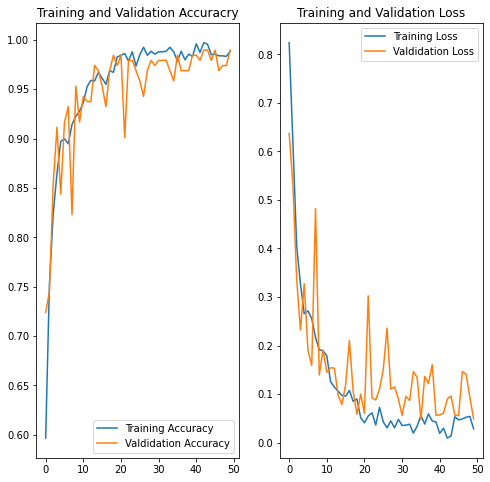

In [25]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,Label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,Label='Valdidation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracry')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,Label='Training Loss')
plt.plot(range(EPOCHS),val_loss,Label='Valdidation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First image to predict
actual label:  Potato___Late_blight
Predicted label:  Potato___Late_blight


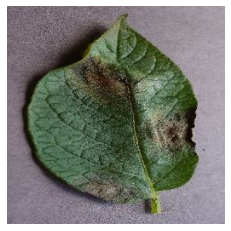

In [32]:
for image_batch,label_batch in dataset.take(1):
  first_image=image_batch[0].numpy().astype('uint8')
  first_label=class_names[label_batch[0].numpy()]

  print('First image to predict')
  plt.imshow(first_image)
  print('actual label: ',first_label)

  batch_predict=model.predict(image_batch)
  print('Predicted label: ',class_names[np.argmax(batch_predict[0])])

  plt.axis('off')

In [35]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100* (np.max(predictions[0])),2)

  return predicted_class, confidence

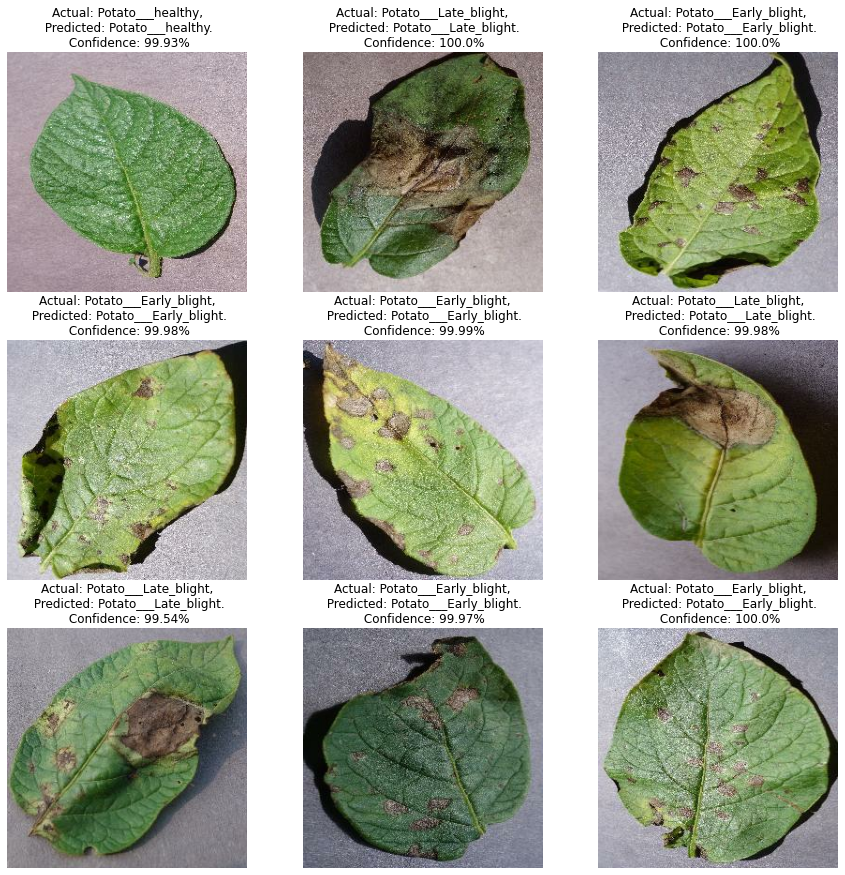

In [39]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))        

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [44]:
model_version=1
tf.keras.models.save_model(model,f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1/assets


INFO:tensorflow:Assets written to: models/1/assets


In [45]:
!zip -r models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/1/ (stored 0%)
  adding: content/models/1/assets/ (stored 0%)
  adding: content/models/1/keras_metadata.pb (deflated 94%)
  adding: content/models/1/variables/ (stored 0%)
  adding: content/models/1/variables/variables.index (deflated 71%)
  adding: content/models/1/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: content/models/1/saved_model.pb (deflated 89%)
